# Chapter 10: Attribute-Control in Variational Autoencoders




***
“Technology advanced enough is indistinguishable from magic.”


--Arthur C. Clarke (author of 2001: A Space Odyssey)
***

We discussed the idea behind variational autoencoders (VAEs) in Chapter 9 and you applied the method on the Fashion MNIST dataset. Without even using convolutional layers, you learned to train a variational autoencoder to encode gray-scale clothes items. The decoder in the trained model is able to regenerate clothes items that are fairly close to the original items. 

In this chapter, you'll add convolutional layers to a VAE and apply the model to color images of human faces. The trained VAE generates high-resolution color images. More important, you'll learn how to control encodings to generate images with certain attributes. For example, by using a weighted average of the encodings of women with eye glasses and women without glasses, the model can produce a series of images that gradually transition from images with glasses to images without glasses. The eye glasses become less and less visible during transition before disappearing completely. You can apply the same method to transition images of men without glasses to images of men with glasses and so on.

You'll also learn to perform encoding arithmetic for certain attributes. For example, if you take the encodings of men with glasses, minus encodings of men without glasses, and add in the encodings of women without glasses, you'll generate images of women with glasses. Similarly, if you take encodings of women with glasses, minus encodings of women without glasses, and add encodings of men without glasses, you'll generate images of men with glasses. The whole experience seems like straight out of science fiction, hence the opening quote by the science fiction writer Arthur Clarke: “Technology advanced enough is indistinguishable from magic.”

To give you an idea what the chapter will accomplish, here is the transition from women with glasses to women without glasses:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/wgwng6.png" />
Transition from women without glasses to men without glasses
<img src="https://gattonweb.uky.edu/faculty/lium/ml/wngmng6.png" />
Two examples of encoding arithmetic:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/vectorArithmetic1.png" />

<img src="https://gattonweb.uky.edu/faculty/lium/ml/vectorArithmetic2.png" />








Start a new cell in ch10.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch10", exist_ok=True)

# 1. A Variational Autoencoder with Convolutional Layers
We'll create a variational autoencoder with convolutional layers. The convolutional layers extract spatial features on images and use them to generate high resolution color pictures. We'll then apply the model to the human face images with and without eye glasses: the same dataset that you processed in Chapter 7. About half of the dataset are men and the other half are women. At the same time, about half of the images have eye glasses and the other half have no eye glasses.

## 1.1. The Faces/Glasses Dataset
We'll first import the libraries we need for this chapter, as follows:

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

If you recall, the eye glasses data are saved in the folder /Desktop/ai/files/ch07/data/ on your computer. We'll transform the data to 256 by 256 pixels color images with values between 0 and 1. We then create a batch iterator with 16 images in each batch:

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
transforms.ToTensor(),
])

data = torchvision.datasets.ImageFolder(
    root="/Desktop/ai/files/ch07/data/",
    transform=transform)

batch_size=16
    
loader = torch.utils.data.DataLoader(data,
     batch_size=batch_size,shuffle=True)

Next, we'll create a variational autoencoder that includes convolutional layers. 

## 1.2. A Variational Encoder
We first create a variational encoder to decompress the images to the latent space. In particular, we'll calculate the mean and standard deviation of each image in the latent space. The encoder is defined as follows:

In [4]:
latent_dims=100
class Encoder(nn.Module):
    def __init__(self, latent_dims=100):  
        super().__init__()
        # input 256 by 256 by 3 channels
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        # 128 by 128 with 8 channels
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # 64 by 64 with 16 channels
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        # 31 by 31 with 32 channels
        self.linear1 = nn.Linear(31*31*32, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std*self.N.sample(mu.shape)
        return mu, std, z  

We added several layers of convolutional layers in the encoder to extract the spatial features on the images. Make sure that the number of channels and image size match when the images go from one layer to the next. When we use convolutional layers with a stride of 2, the image size (i.e., height and width) decreases by 50%. Go back to Chapter 2 on how convolutional layers work if you need to refresh your memory on convolutional layers. 

The output from the encoder are three variables: *mu*, *std*, and *z*, the mean, standard deviation, and encoding of the image in the latent space. 

## 1.3. A Variation Decoder with Convolutional Layers
We'll create a variationa decoder to convert encodings from the latent space to images. 

In [5]:
class Decoder(nn.Module):   
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 31*31 * 32),
            nn.ReLU(True))
        self.unflatten = nn.Unflatten(dim=1, 
                  unflattened_size=(32,31,31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,stride=2,
                               output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1))
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x  

The decoder is a mirror image of the encoder: instead of performing convolutional operations, it performs transpose convolutional operations on the inputs. It gradually converts the encoding in the latent space back into (256 by 256 pixels) color images. 

## 1.4. A Variational Autoencoder
We'll combine the variational encoder with the variational decoder to create a variational autoencoder, like so:

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z) 

Next, we instantiate a variational autoencoder and define the optimizer for the model:

In [7]:
device="cuda" if torch.cuda.is_available() else "cpu"
vae=VAE().to(device)
lr=1e-4 
optimizer=torch.optim.Adam(vae.parameters(),
                           lr=lr,weight_decay=1e-5)

We'll manually calculate the reconstruction loss and the KL-divergence loss during training. Therefore, we'll not define a loss function here. 

Next, we'll train the autoencoder.

# 2. Train the Variational Autoencoder
To train the model, we first define a *train_epoch()* function to train the model for one epoch: 

In [8]:
def train_epoch(epoch):
    vae.train()
    epoch_loss = 0.0
    for imgs, _ in loader: 
        imgs = imgs.to(device)
        mu, std, out = vae(imgs)
        # reconstruction loss
        reconstruction_loss = ((imgs-out)**2).sum() 
        # kl loss
        kl = (std**2 + mu**2 - torch.log(std) - 0.5).sum()
        # loss
        loss = reconstruction_loss + kl
        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        epoch_loss+=loss.item()
    print(f'at epoch {epoch}, loss is {epoch_loss}')  

The loss is the sum of the reconstruction loss and the KL-divergence. We manually calculate those losses. The reconstruction loss is the mean squared error between the original image and the reconstructed image. 

We also define a *test()* function after each epoch to display 16 reconstructed images so that we can see how the model is performing during the training process. 

In [9]:
def test():
    with torch.no_grad():
        noise = torch.randn(16,latent_dims).to(device)
        imgs = vae.decoder(noise).cpu()
        imgs = torchvision.utils.make_grid(imgs,4,4).numpy()
        fig, ax = plt.subplots(figsize=(20,20),dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()       

In the *test()* function, we reconstruct 16 images by using the trained model and display them on a four by four grid.

Below, we train the model for ten epochs:

In [10]:
for epoch in range(1,11):
    train_epoch(epoch)
    test()

The above training takes a few minutes. After training, we save the trained weights of the model in the local folder. 

In [11]:
torch.save(vae.state_dict(),"files/ch10/celebVAE.pth")

# 3. Generate Images with the Trained Model
In this section, we'll first generate human face images by using the trained model. We then hand select three images from each of the following four groups: men with glasses, men without glasses, women with glasses, and women without glasses. We'll retrieve the encodings of each image and average them within each group. We'll then perform encoding arithmetic to generate various images.

## 3.1. Reconstruct Images
We first load the weights of the trained model that we saved in the local folder, as follows:

In [12]:
vae.eval()

vae.load_state_dict(torch.load('files/ch10/celebVAE.pth'))

<All keys matched successfully>

We can reconstruct 16 images by using the trained model:

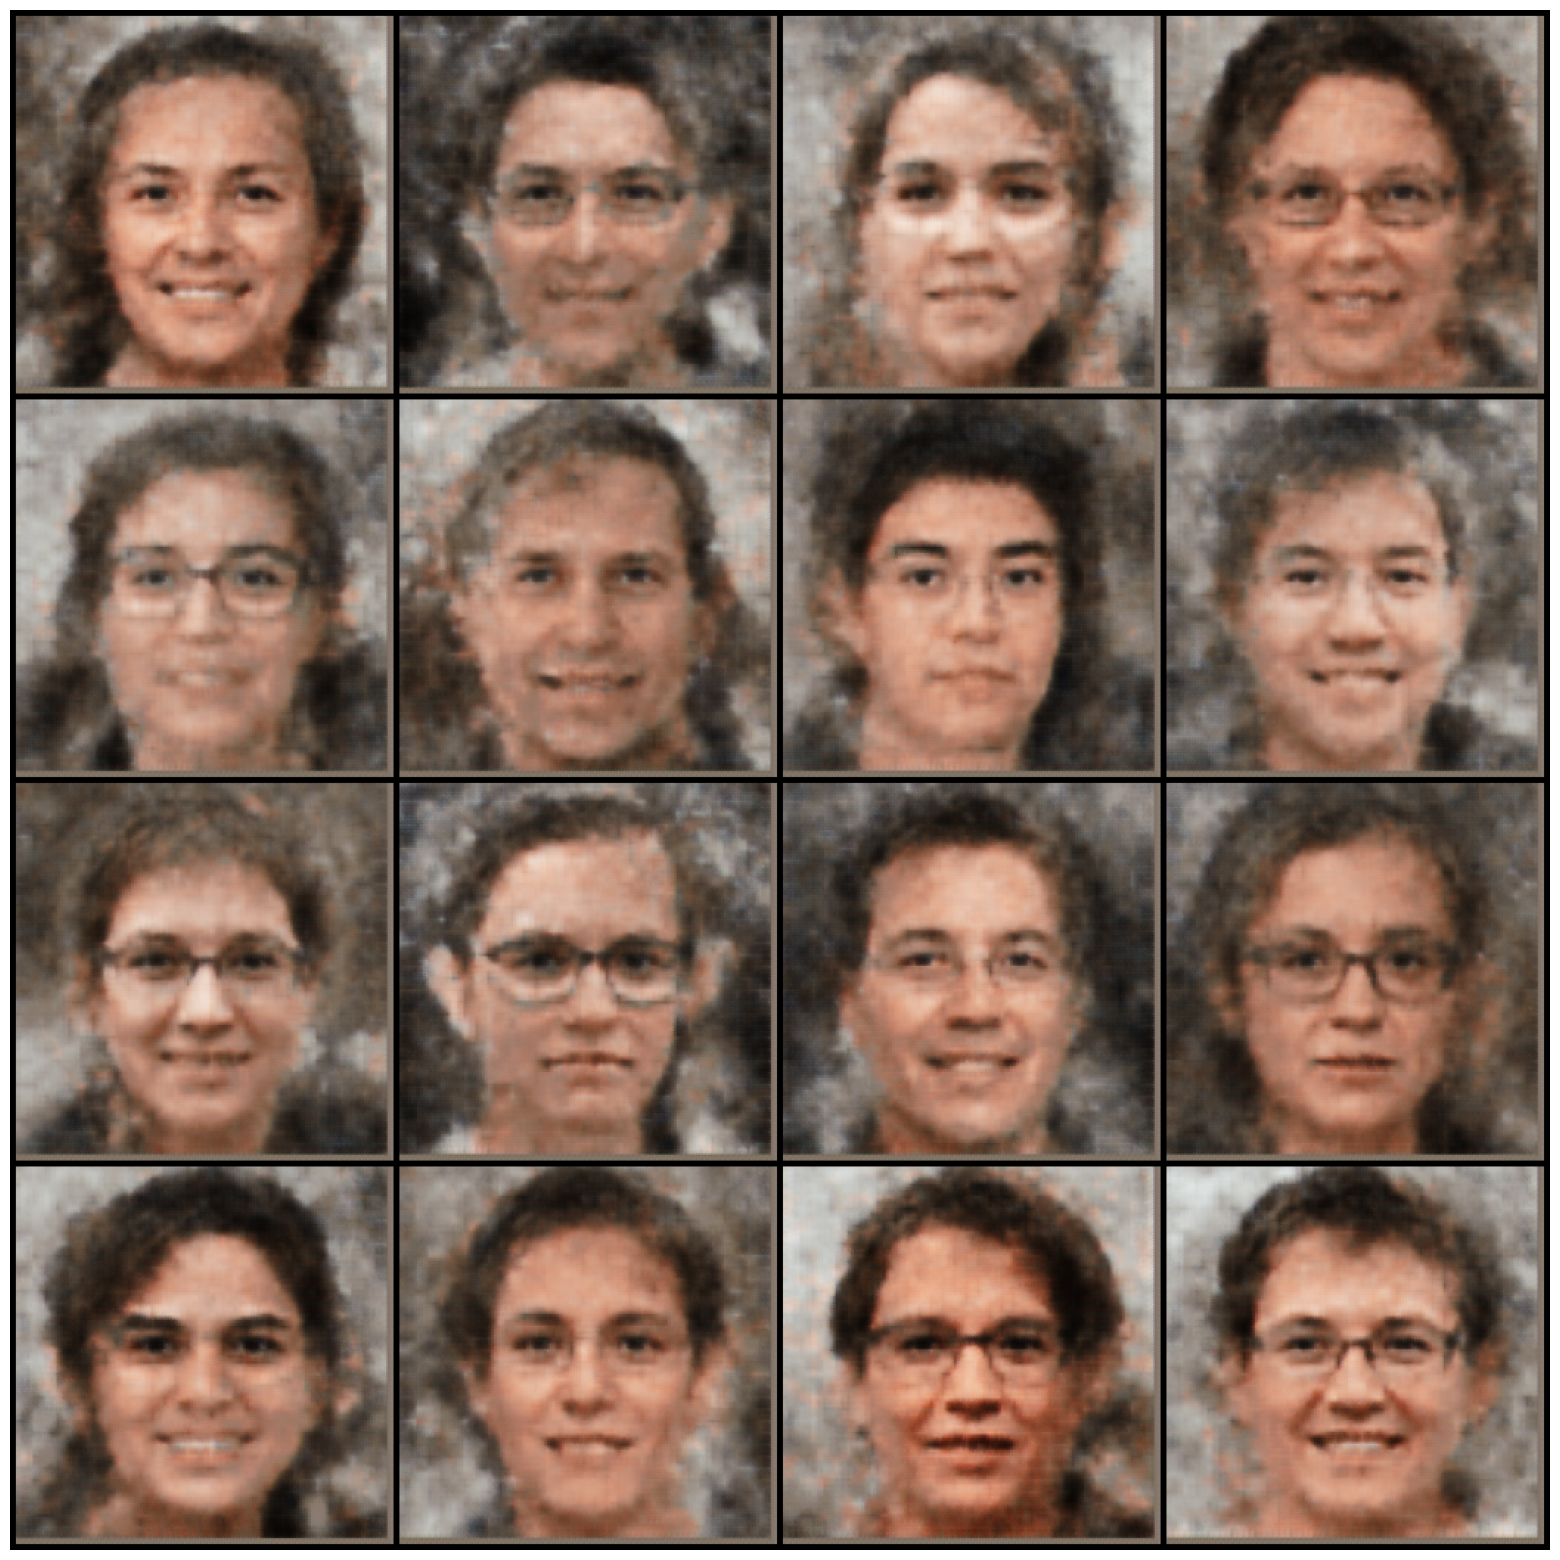

In [13]:
noise = torch.randn(16,latent_dims).to(device)
imgs = vae.decoder(noise).cpu()
imgs = torchvision.utils.make_grid(imgs,4,4).numpy()
fig, ax = plt.subplots(figsize=(20,20),dpi=100)
plt.imshow(np.transpose(imgs, (1, 2, 0)))
plt.axis("off")
plt.show()   

The facial features are very realistic, but the model chooses to ignore the background. In particular, since half of our training data are images with glasses and the other half are images without glasses, the generated images above have both types of images. 

## 3.2. Retrieve the Encodings in the Latent Space
We'll first hand collect three images in each of these four groups: men with glasses, men without glasses, women with glasses, and women without glasses. 

In [14]:
# collect 25 five images with glasses
glasses=[]
for i in range(25):
    img,label=data[i]
    glasses.append(img)
# select three men's images    
men_g=[glasses[0],glasses[3],glasses[14]]
# select three women's images    
women_g=[glasses[9],glasses[15],glasses[21]]

# collect 25 five images without glasses
noglasses=[]
for i in range(25):
    img,label=data[-i]
    noglasses.append(img)
# select three men's images    
men_ng=[noglasses[2],noglasses[7],noglasses[8]]
# select three women's images    
women_ng=[noglasses[3],noglasses[5],noglasses[10]]

For each group of images, we use *torch.cat()* to put them as a batch so that we can feed them to the trained model:

In [15]:
men_g_batch = torch.cat((men_g[0].unsqueeze(0),
             men_g[1].unsqueeze(0),
             men_g[2].unsqueeze(0)), dim=0).to(device)
women_g_batch = torch.cat((women_g[0].unsqueeze(0),
             women_g[1].unsqueeze(0),
             women_g[2].unsqueeze(0)), dim=0).to(device)
men_ng_batch = torch.cat((men_ng[0].unsqueeze(0),
             men_ng[1].unsqueeze(0),
             men_ng[2].unsqueeze(0)), dim=0).to(device)
women_ng_batch = torch.cat((women_ng[0].unsqueeze(0),
             women_ng[1].unsqueeze(0),
             women_ng[2].unsqueeze(0)), dim=0).to(device)

We feed the batched images to the trained model and use the *encoder()* method in the model to generate the encodings of the images, like so:

In [16]:
# Obtain the three encodings
_,_,men_g_encodings=vae.encoder(men_g_batch)
# Average over the three images
men_g_encoding=men_g_encodings.mean(dim=0)
# Do the same for the other three groups
_,_,women_g_encodings=vae.encoder(women_g_batch)
women_g_encoding=women_g_encodings.mean(dim=0)
_,_,men_ng_encodings=vae.encoder(men_ng_batch)
men_ng_encoding=men_ng_encodings.mean(dim=0)
_,_,women_ng_encodings=vae.encoder(women_ng_batch)
women_ng_encoding=women_ng_encodings.mean(dim=0)

We can use the averge encodings in each group to reconstruct images, as follows:

In [17]:
men_g_recon=vae.decoder(men_g_encoding.unsqueeze(0))
women_g_recon=vae.decoder(women_g_encoding.unsqueeze(0))
men_ng_recon=vae.decoder(men_ng_encoding.unsqueeze(0))
women_ng_recon=vae.decoder(women_ng_encoding.unsqueeze(0))

We can plot the four reconstructed images as follows:

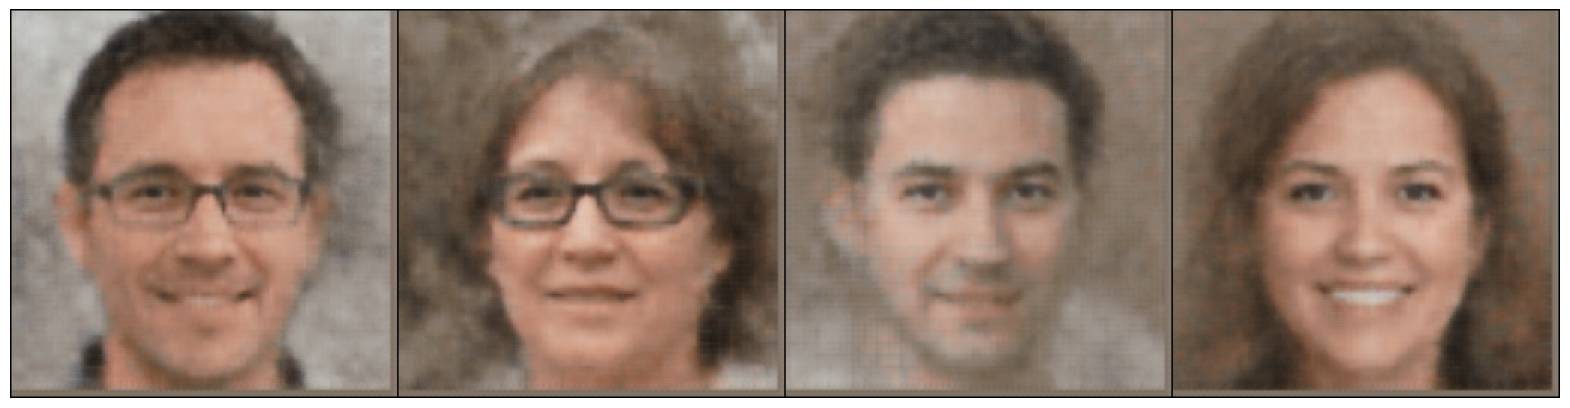

In [18]:
imgs=torch.cat((men_g_recon,
                women_g_recon,
                men_ng_recon,
                women_ng_recon),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(20, 20),dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

The above four images are the reconstructed images based on average encodings in each group. 

## 3.3. Encoding Arithmetics
First, we'll subtract the average encoding of women with glasses from the average encoding of men with glasses and add the average encoding of women without glasses. We then feed the result to the decoder and see what we have:

In [19]:
z=men_g_encoding-women_g_encoding+women_ng_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_g_recon,
                women_g_recon,
                women_ng_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(20, 20),dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

The result looks like this:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/vectorArithmetic1.png" />

Next, we'll subtract the average encoding of men without glasses from the average encoding of men with glasses and add the average encoding of women without glasses. We then feed the result to the decoder and see what we have:

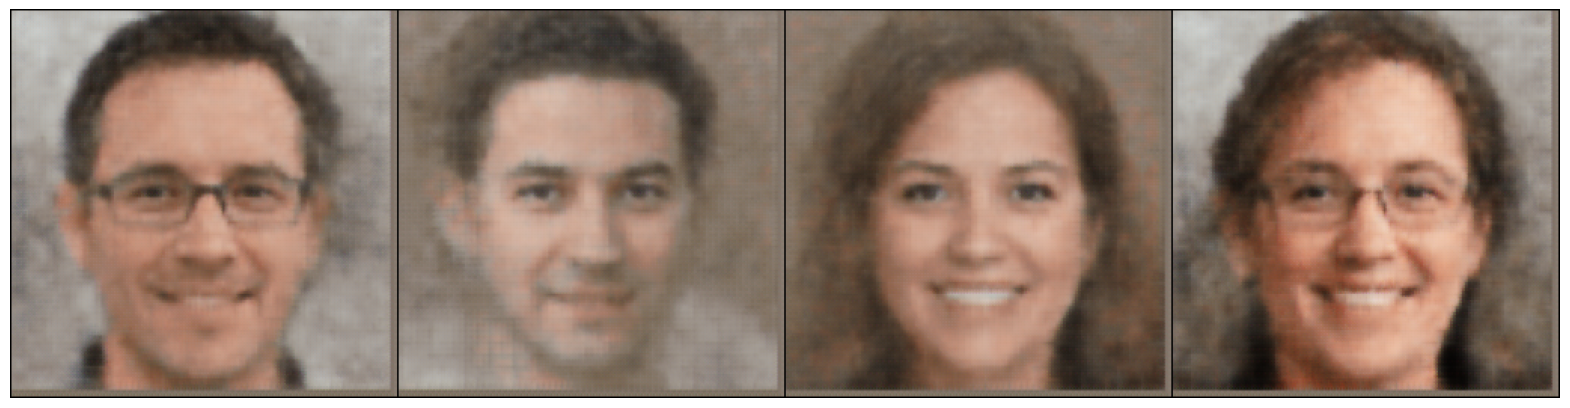

In [20]:
z=men_g_encoding-men_ng_encoding+women_ng_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_g_recon,
                men_ng_recon,
                women_ng_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(20, 20),dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

If you subtract the average encoding of women without glasses from the average encoding of men without glasses and add the average encoding of men with glasses, we have this:

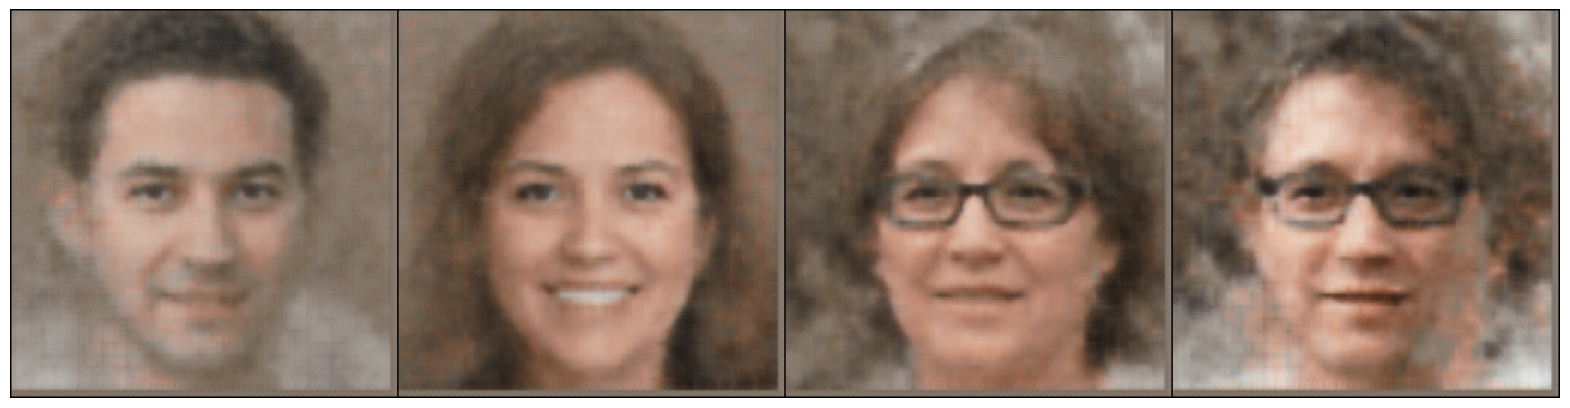

In [21]:
z=men_ng_encoding-women_ng_encoding+women_g_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_ng_recon,
                women_ng_recon,
                women_g_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(20, 20),dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

The result looks like this:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/vectorArithmetic2.png" />

## 3.4 Transitioning from One Goup to Another
If you use a weighted average of the encodings of men without eye glasses and men with glasses, the model can produce a series of images that gradually transition from one group to another:

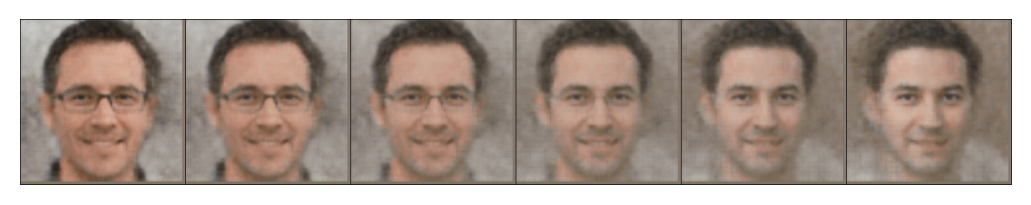

In [22]:
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*men_ng_encoding+(1-w)*men_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=200)
plt.imshow(imgs)
plt.axis("off")
plt.show()  

The weight we put on the average encoding of men without glasses changes from 0% to 20% to 40%...  all the way to 100%. The above six images show the gradual transition based on the mixed weights. 

Similarly, if you use a weighted average of the encodings of women without eye glasses and men without glasses, the model can produce a series of images that gradually transition from women to men, all without glasses:

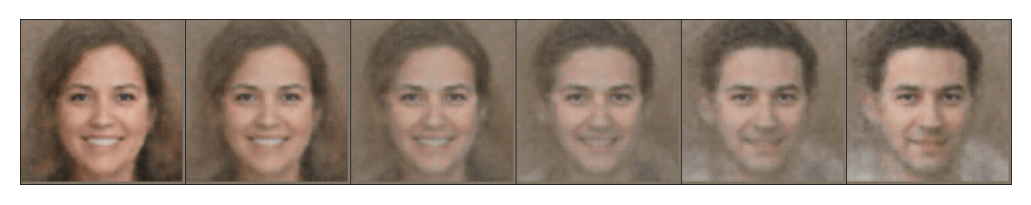

In [23]:
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*men_ng_encoding+(1-w)*women_ng_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=200)
plt.imshow(imgs)
plt.axis("off")
plt.show()  

Below is the transition from women with glasses to women without glasses:

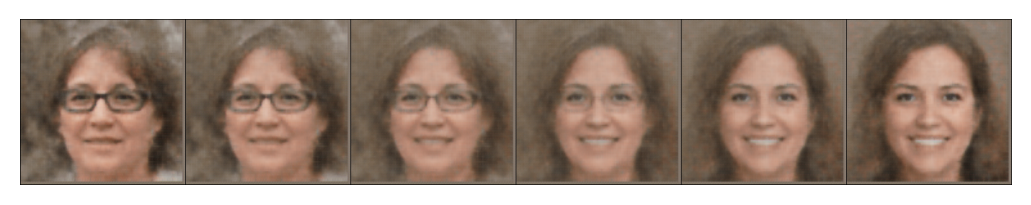

In [24]:
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*women_ng_encoding+(1-w)*women_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=200)
plt.imshow(imgs)
plt.axis("off")
plt.show() 

The transition from women with glasses to men with glasses:

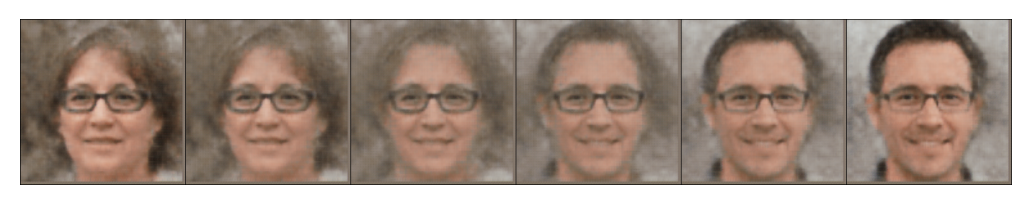

In [25]:
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*men_g_encoding+(1-w)*women_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=200)
plt.imshow(imgs)
plt.axis("off")
plt.show() 

You can also try other types of transitions, such as from women with glasses to men without glasses... and so on. But I'll leave those as exercises for you. 